<a href="https://colab.research.google.com/github/VictoKu1/Anomaly_Detection/blob/master/Task1_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anomaly Detection**

---

---

##### **_Authors:_** _Moriya Bitton & Victor Kushnir_

---

---


##### **[Github Link](https://github.com/VictoKu1/Anomaly_Detection)**

---

---

## **Part 0 - Imports** 

---



---



In [63]:
import io
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, f1_score

## **Part 1 - Data** 

---



---



In [64]:
data_to_load = files.upload()
target_to_load = files.upload()

Saving conn_attack.csv to conn_attack (2).csv


Saving conn_attack_anomaly_labels.csv to conn_attack_anomaly_labels (2).csv


In [65]:
# Reading the data and fixing columns names

df = pd.read_csv(io.BytesIO(data_to_load['conn_attack.csv']), 
                 names=["record_id", "Duration_", "src_bytes", "dst_bytes"], 
                 index_col='record_id')
columns = df.columns

target = pd.read_csv(io.BytesIO(target_to_load['conn_attack_anomaly_labels.csv']), 
                 names=["id", "label"], 
                 index_col='id')

In [66]:
df.head()

,Duration_,src_bytes,dst_bytes
record_id,,,
1,0,236,1228
2,0,239,486
3,0,234,1364
4,0,239,1295
5,0,181,5450


In [67]:
target.head()

,label
id,
1,0
2,0
3,0
4,0
5,0


##### **Shape**

In [68]:
df.shape

(256670, 3)

In [69]:
columns.shape

(3,)

In [70]:
target.shape

(256670, 1)

##### **Analyzing the data frame** 

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256670 entries, 1 to 256670
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Duration_  256670 non-null  int64
 1   src_bytes  256670 non-null  int64
 2   dst_bytes  256670 non-null  int64
dtypes: int64(3)
memory usage: 7.8 MB


In [72]:
df.describe()

,Duration_,src_bytes,dst_bytes
count,256670.000000,256670.000000,2.566700e+05
mean,0.640936,474.247898,4.473533e+03
std,15.627170,3391.106084,2.080903e+04
min,0.000000,0.000000,0.000000e+00
25%,0.000000,217.000000,6.600000e+02
50%,0.000000,249.000000,1.661000e+03
75%,0.000000,306.000000,4.341000e+03
max,3289.000000,54540.000000,7.068759e+06


##### **Data visualization**

[Text(0.5, 1.0, 'dst_bytes')]

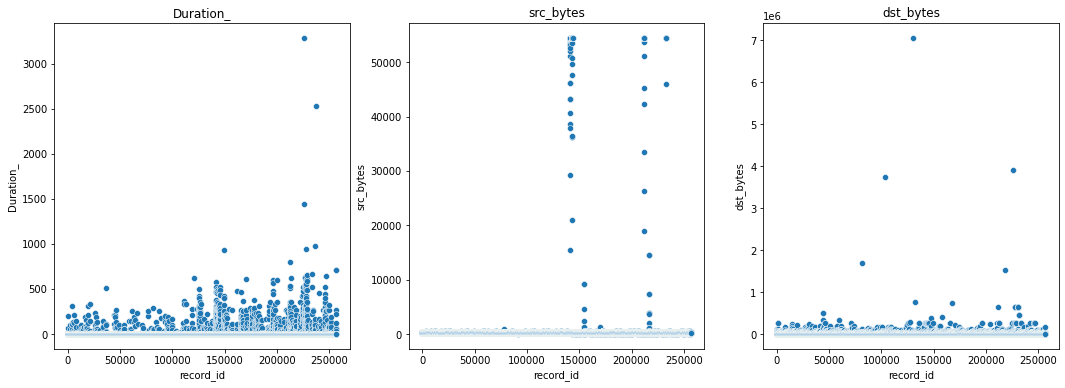

In [73]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

# Data distributed on the "Duration_" feature only
sns.scatterplot(data=df.Duration_, ax=axes[0]).set(title="Duration_")

# Data distributed on the "src_bytes" feature only
sns.scatterplot(data=df.src_bytes, ax=axes[1]).set(title="src_bytes")

# Data distributed on the "dst_bytes" feature only
sns.scatterplot(data=df.dst_bytes, ax=axes[2]).set(title="dst_bytes")

## **Part 2 - Possible labels to compare**

---



---



##### **Assumption**

Essentially, we want to find ways to locate outliers without relying on any model to find the most appropriate model.

We found that the clustering algorithms will probably work because the data is mostly clustered in the center and only a small amount is scattered far away from it. 

As a result, _Isolation Forests_ won't work, but _DBSCAN_ will.

In [74]:
q_low_1 = df.Duration_.quantile(0.01)
q_hi_1 = df.Duration_.quantile(0.99)

q_low_2 = df.src_bytes.quantile(0.01)
q_hi_2  = df.src_bytes.quantile(0.99)

q_low_3 = df.dst_bytes.quantile(0.01)
q_hi_3  = df.dst_bytes.quantile(0.99)

# Creating the guess
guess = np.zeros_like(df.src_bytes)

guess[
    (df.Duration_ < q_low_1) | (df.Duration_ > q_hi_1) | 
    (df.src_bytes < q_low_2) | (df.src_bytes > q_hi_2) | 
    (df.dst_bytes < q_low_3) | (df.dst_bytes > q_hi_3)
    ] = 1 

## **Part 3 - Models**


---



---




In [75]:
# Finding important features

df0 = df.drop(columns=columns[0])
df1 = df.drop(columns=columns[1])
df2 = df.drop(columns=columns[2])

df01 = df.drop(columns=[columns[0], columns[1]])
df02 = df.drop(columns=[columns[0], columns[2]])
df12 = df.drop(columns=[columns[1], columns[2]])

### ***3.1 - Isolation Forest***


In [76]:
# Find if Isolation Forest might have good prediction

def run_isf_models(max_f_, df):
  isf_pred = []
  for i in range(100, 1000, 100):
      isf = IsolationForest(n_estimators=i, max_features=max_f_, n_jobs=-1)
      isf_labels = pd.Series(isf.fit_predict(df))
      isf_labels = isf_labels.map({1: 0, -1: 1})
      isf_pred.append([i, f1_score(y_true=guess, y_pred=isf_labels)])

  sns.lineplot(x=np.array(isf_pred)[:, 0], y=np.array(isf_pred)[:, 1])  

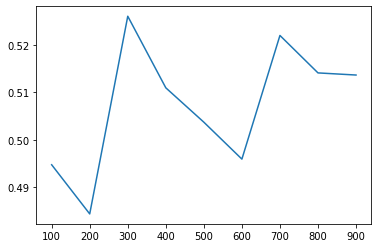

In [77]:
# Running the model using all features

run_isf_models(3, df)

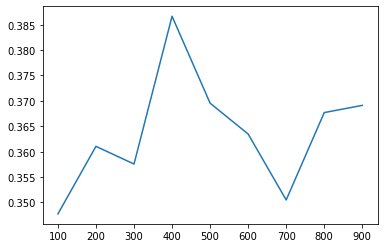

In [78]:
# Running the model without "Duration_"

run_isf_models(2, df0)

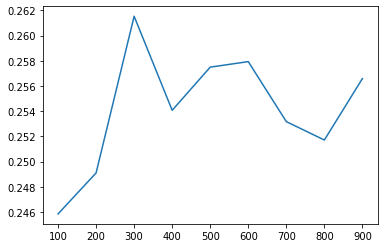

In [79]:
# Running the model without "src_bytes"

run_isf_models(2, df1)

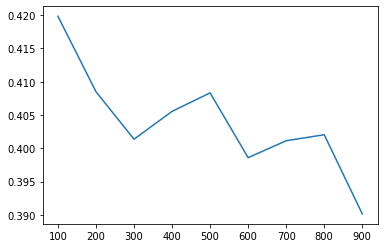

In [80]:
# Running the model without "dst_bytes"

run_isf_models(2, df2)

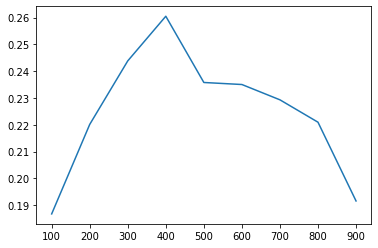

In [81]:
# Running the model without "Duration_" , "src_bytes"

run_isf_models(1, df01)

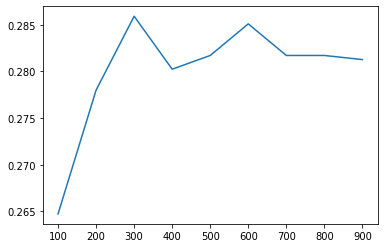

In [82]:
# Running the model without "Duration_" , "dst_bytes"

run_isf_models(1, df02)

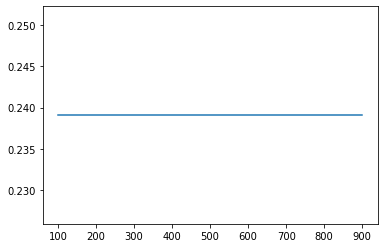

In [83]:
# Running the model without "src_bytes" , "dst_bytes"

run_isf_models(1, df12)

### ***3.2 - DBSCAN***

In [84]:
# Mapping function to fit the correct labels

def _map(x):
  return 0 if x==-1 else 1
  
# Find if DBSCAN might have good prediction

def run_dbs_models(df):
  dbs_pred = []
  for i in range(50, 300, 50):
      dbs = DBSCAN(min_samples=i)
      dbs_labels = pd.Series(dbs.fit_predict(df))
      dbs_labels = dbs_labels.apply(lambda x: _map(x))
      dbs_pred.append([i, f1_score(y_true=guess, y_pred=dbs_labels)])

  sns.lineplot(x=np.array(dbs_pred)[:, 0], y=np.array(dbs_pred)[:, 1])

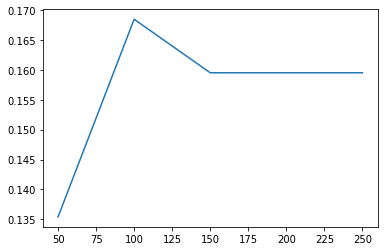

In [85]:
# Running the model using all features

run_dbs_models(df)

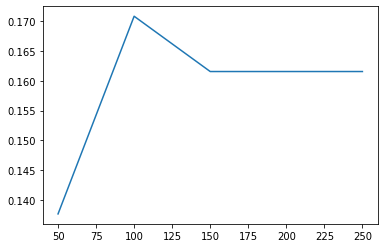

In [86]:
# Running the model without "Duration_"

run_dbs_models(df0)

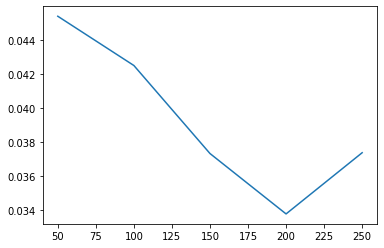

In [87]:
# Running the model without "src_bytes"

run_dbs_models(df1)

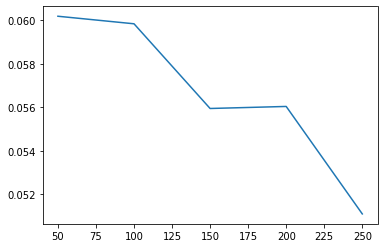

In [88]:
# Running the model without "dst_bytes"

run_dbs_models(df2)

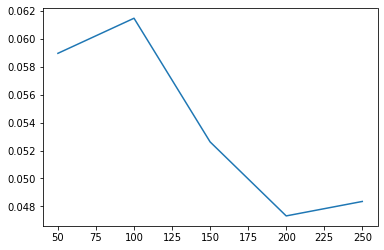

In [89]:
# Running the model without "Duration_" , "src_bytes"

run_dbs_models(df01)

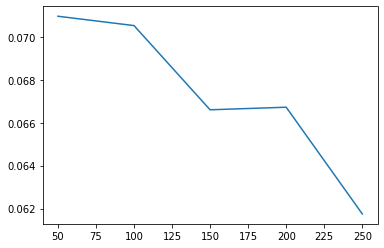

In [90]:
# Running the model without "Duration_" , "dst_bytes"

run_dbs_models(df02)

In [91]:
# Running the model without "src_bytes" , "dst_bytes"

# run_dbs_models(df12) --> Memory error!

## **Part 4 - Evaluation & Comparison**

---

---



In [92]:
dbs = DBSCAN(min_samples=150, n_jobs=-1)
dbs_labels = pd.Series(dbs.fit_predict(df)).apply(lambda x: _map(x))

##### ***y_guess & y_dbs***

In [93]:
confusion_matrix(y_true=guess, y_pred=dbs_labels)

array([[245608,      0],
       [ 10103,    959]])

In [94]:
print(classification_report(y_true=guess, y_pred=dbs_labels))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    245608
           1       1.00      0.09      0.16     11062

    accuracy                           0.96    256670
   macro avg       0.98      0.54      0.57    256670
weighted avg       0.96      0.96      0.94    256670



##### ***y_guess & y_true***

In [95]:
confusion_matrix(y_true=guess, y_pred=target.label)

array([[245608,      0],
       [ 10040,   1022]])

In [96]:
print(classification_report(y_true=guess, y_pred=target.label))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    245608
           1       1.00      0.09      0.17     11062

    accuracy                           0.96    256670
   macro avg       0.98      0.55      0.57    256670
weighted avg       0.96      0.96      0.95    256670



##### ***y_dbs & y_true***

In [97]:
confusion_matrix(y_true=dbs_labels, y_pred=target.label)

array([[255647,     64],
       [     1,    958]])

In [98]:
print(classification_report(y_true=dbs_labels, y_pred=target.label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    255711
           1       0.94      1.00      0.97       959

    accuracy                           1.00    256670
   macro avg       0.97      1.00      0.98    256670
weighted avg       1.00      1.00      1.00    256670



## **Part 5 - Export the output**

---

---

In [99]:
DBS_labels = DBS_labels.set_axis(target.index)
df["is_anomaly"] = DBS_labels

output = df.drop(columns=["Duration_", "src_bytes", "dst_bytes"])

In [100]:
output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256670 entries, 1 to 256670
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   is_anomaly  256670 non-null  int64
dtypes: int64(1)
memory usage: 3.9 MB


In [101]:
output.head()

,is_anomaly
record_id,
1,0
2,0
3,0
4,0
5,0


In [102]:
output.describe()

,is_anomaly
count,256670.000000
mean,0.003736
std,0.061011
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [103]:
output.corr()

,is_anomaly
is_anomaly,1.0


In [104]:
output.to_csv('output.csv', encoding='utf-8', index=False)

## **Part 6 - Conclusion**

---

---



*   According to the F_scores, the isolation forest is not the right solution.

*   DBSCAN does fit this problem

*   While "src_bytes" is the most important feature, utilizing all features helps detect outliers more effectively.

*   Our guesses weren't accurate.

*   There is a high correlation between the real label and the prediction, which means that the prediction is very close to the real label. 



# **The End**

---


---

